# Prepare DF

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

module_path

'/home/tjanicek/thesis/thoth-issue-predictor'

In [2]:
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from catboost import Pool, CatBoostClassifier
from datetime import datetime
from thoth_issue_predictor.evaluation.metrics import Metrics
from thoth_issue_predictor.evaluation.model_evaluation import ModelEvaluation

from thoth_issue_predictor.utils.preprocessing import (
    prepare_df,
    create_python_version_packege_df,
)

In [3]:
FILE_NAME = "../datasets/dataset.zip"
inspections_df = prepare_df(FILE_NAME)
exit_codes = inspections_df["exit_code"]

In [4]:
(
    issues_df,
    _,
    python_indexes,
) = create_python_version_packege_df(inspections_df=inspections_df)
issues_df["exit_code"] = exit_codes.astype("int")
issues_df = issues_df.loc[
    (issues_df.loc[:, issues_df.columns != "exit_code"] != 0).any(axis=1)
]
issues_df = issues_df.drop_duplicates()

In [5]:
python_indexes

['unknown', 'pypi-org-simple', 'pypi-org', 'aicoe', 'pypi']

In [6]:
print(f"Length of DF is {len(issues_df)}")
issues_df.head(5)

Length of DF is 1947


,python,tensorflow_major,tensorflow_minor,tensorflow_patch,tensorflow_index,flatbuffers_major,flatbuffers_minor,flatbuffers_patch,flatbuffers_index,six_major,...,pyyaml_index,torch_major,torch_minor,torch_patch,torch_index,tensorflow-cpu_major,tensorflow-cpu_minor,tensorflow-cpu_patch,tensorflow-cpu_index,exit_code
0,38,2,4,1,1,1,12,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,38,2,4,1,1,1,12,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,38,2,4,1,1,1,12,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,38,2,4,0,1,1,12,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
issues_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1947 entries, 0 to 1999
Columns: 234 entries, python to exit_code
dtypes: int64(234)
memory usage: 3.5 MB


# Failed inspections

In [8]:
failed_inspections = issues_df[issues_df["exit_code"] == 1]
print(f"Number of failed inspections: {len(failed_inspections)}")
failed_inspections.head()

Number of failed inspections: 102


,python,tensorflow_major,tensorflow_minor,tensorflow_patch,tensorflow_index,flatbuffers_major,flatbuffers_minor,flatbuffers_patch,flatbuffers_index,six_major,...,pyyaml_index,torch_major,torch_minor,torch_patch,torch_index,tensorflow-cpu_major,tensorflow-cpu_minor,tensorflow-cpu_patch,tensorflow-cpu_index,exit_code
1896,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1897,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1898,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1899,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1900,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [9]:
issue_x, exit_codes = issues_df.drop("exit_code", axis=1), issues_df["exit_code"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    issue_x, exit_codes, test_size=0.4, random_state=0
)

# Decision Trees

## Scikit CART model

In [11]:
tuned_parameters = [
    {
        "splitter": ["best", "random"],
        "max_depth": [3, 4, 5],
        "min_samples_split": [2, 5, 8],
        "min_samples_leaf": [1, 3, 5],
        "random_state": [20, 50, 100],
    }
]

clf = GridSearchCV(DecisionTreeClassifier(), tuned_parameters)
clf.fit(X_train, y_train)

best_params = clf.best_params_
best_params

{'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 100,
 'splitter': 'random'}

In [12]:
clf = DecisionTreeClassifier(**best_params)

start = datetime.now()
clf.fit(X_train, y_train)
end = datetime.now()

pred = clf.predict(X_test)

In [13]:
feature_names = issue_x.columns
target_names = ["successful", "failed"]
dot_data = export_graphviz(
    clf,
    out_file=None,
    feature_names=feature_names,
    class_names=target_names,
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = graphviz.Source(dot_data)
graph.render("trees/ThothIssuePredictor", format="pdf")

'trees/ThothIssuePredictor.pdf'

Train time: 0:00:00.008962
Number of errors: 9
AUC: 0.9331947331947332
Accuracy Score: 0.9884467265725289
F1 weighted: 0.9883756058139498
F1 micro: 0.9884467265725289
F1 macro: 0.9385199540500013
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       740
           1       0.89      0.87      0.88        39

    accuracy                           0.99       779
   macro avg       0.94      0.93      0.94       779
weighted avg       0.99      0.99      0.99       779

[[736   4]
 [  5  34]]


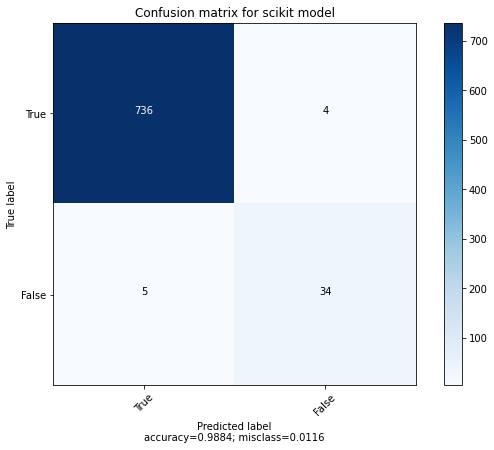

In [14]:
scikit_evaluation = ModelEvaluation("scikit", end - start, y_test, pred)
scikit_evaluation.print()

## CatBoost GBDT model

In [15]:
cat_features = [f for f in feature_names if "_index" in f]

issue_pool = Pool(issue_x, exit_codes, cat_features=cat_features)
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [16]:
params = {
    "verbose": False,
    "eval_metric": "AUC",
    "loss_function": "Logloss",
    "leaf_estimation_iterations": 10,
}

grid = {
    "iterations": [1000, 2000],
    "depth": [4, 5, 6, 7],
    "l2_leaf_reg": [3, 5, 7],
}
model = CatBoostClassifier(**params)
search_results = model.grid_search(grid, X=train_pool, verbose=False)
best_params = search_results["params"]
best_params


bestTest = 0.995734127
bestIteration = 19

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9953373016
bestIteration = 23

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9956349206
bestIteration = 37

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.995734127
bestIteration = 19

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9953373016
bestIteration = 23

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9956349206
bestIteration = 37

Metric AUC is not calculated on train by default. To calculate

{'depth': 6, 'l2_leaf_reg': 3, 'iterations': 1000}

In [26]:
model = CatBoostClassifier(use_best_model=True, **params, **best_params)

In [30]:
model.tree_count_

153

In [28]:
start = datetime.now()
model.fit(train_pool, eval_set=test_pool)
end = datetime.now()

pred = model.predict(test_pool)

In [36]:
dot_data = model.plot_tree(1, pool=train_pool)
graph = graphviz.Source(dot_data)
graph.render("trees/ThothIssuePredictorBoost", format="pdf")

'trees/ThothIssuePredictorBoost.pdf'

Train time: 0:00:09.230016
Number of errors: 1
AUC: 0.9871794871794872
Accuracy Score: 0.9987163029525032
F1 weighted: 0.9987084006459944
F1 micro: 0.9987163029525032
F1 macro: 0.9931688837833335
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       740
           1       1.00      0.97      0.99        39

    accuracy                           1.00       779
   macro avg       1.00      0.99      0.99       779
weighted avg       1.00      1.00      1.00       779

[[740   0]
 [  1  38]]


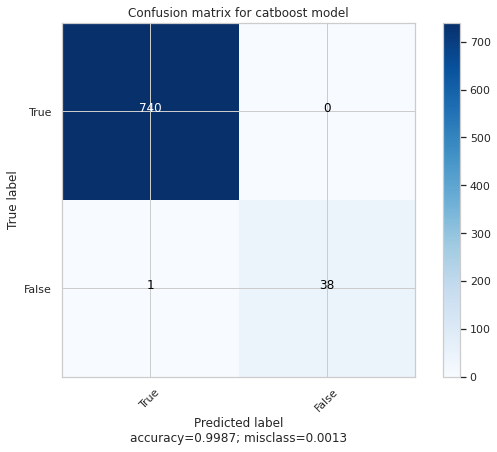

In [29]:
catboost_evaluation = ModelEvaluation("catboost", end - start, y_test, pred)
catboost_evaluation.print()

## Comparison

--------------------------------------------
Results for each category from best to worst
--------------------------------------------
train_time:
1. scikit: 0:00:00.008962
2. catboost: 0:00:12.629265


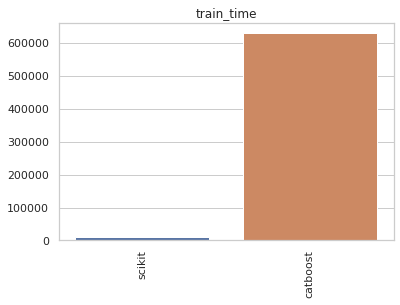

number_of_errors:
1. catboost: 1
2. scikit: 9


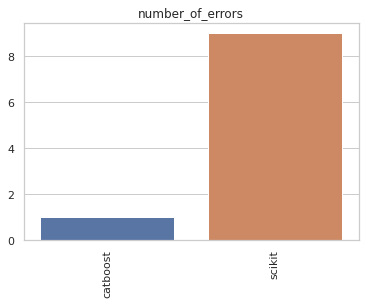

auc:
1. catboost: 0.9871794871794872
2. scikit: 0.9331947331947332


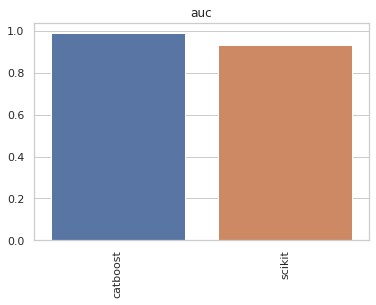

accuracy_score:
1. catboost: 0.9987163029525032
2. scikit: 0.9884467265725289


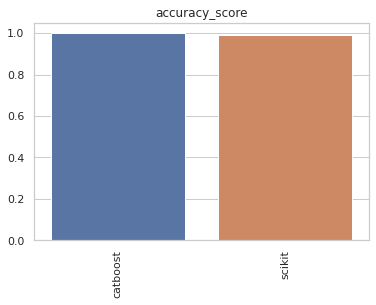

f1_weighted:
1. catboost: 0.9987084006459944
2. scikit: 0.9883756058139498


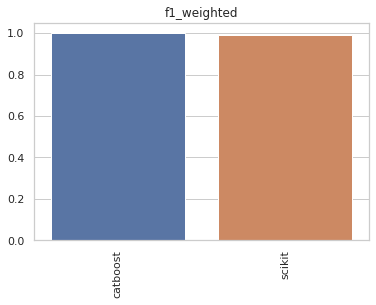

f1_micro:
1. catboost: 0.9987163029525032
2. scikit: 0.9884467265725289


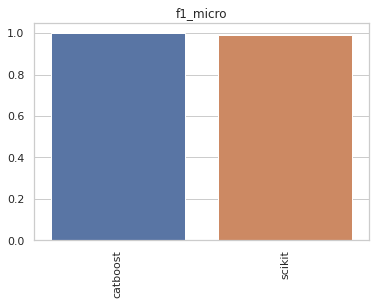

f1_macro:
1. catboost: 0.9931688837833335
2. scikit: 0.9385199540500013


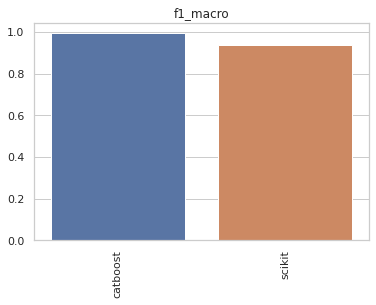

-----------------------------
Best models for each category
-----------------------------
train_time:
1. scikit: 0:00:00.008962
2. catboost: 0:00:12.629265


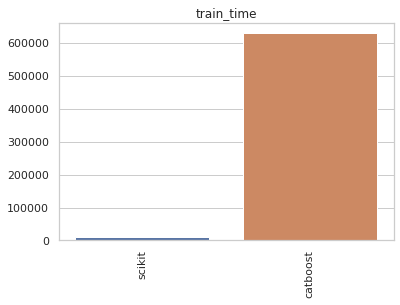

number_of_errors:
1. catboost: 1
2. scikit: 9


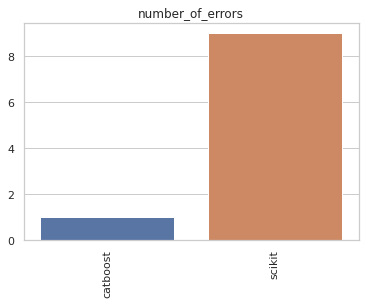

auc:
1. catboost: 0.9871794871794872
2. scikit: 0.9331947331947332


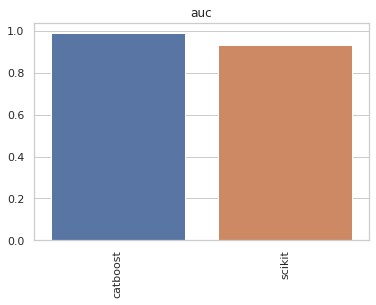

accuracy_score:
1. catboost: 0.9987163029525032
2. scikit: 0.9884467265725289


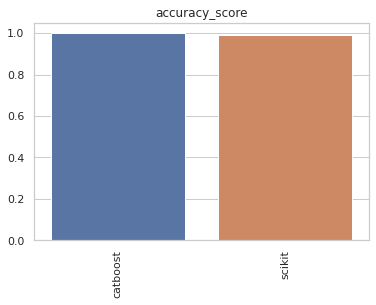

f1_weighted:
1. catboost: 0.9987084006459944
2. scikit: 0.9883756058139498


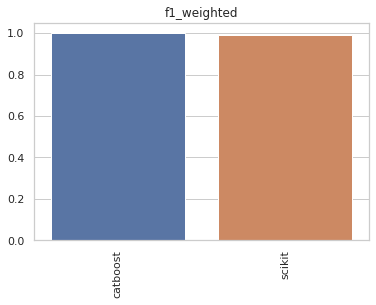

f1_micro:
1. catboost: 0.9987163029525032
2. scikit: 0.9884467265725289


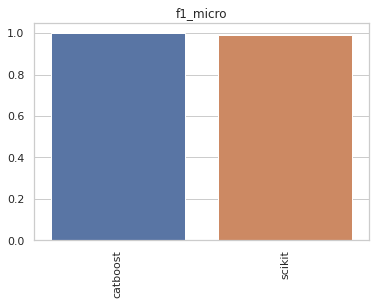

f1_macro:
1. catboost: 0.9931688837833335
2. scikit: 0.9385199540500013


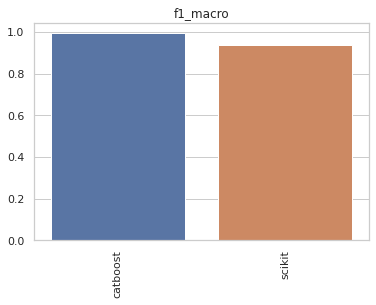

In [21]:
metrics = Metrics([scikit_evaluation, catboost_evaluation])

metrics.sort_metrics()
print("--------------------------------------------")
print("Results for each category from best to worst")
print("--------------------------------------------")
metrics.print_results()

print("-----------------------------")
print("Best models for each category")
print("-----------------------------")
metrics.print_results()